# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display

# Local
from utils.misc import dict_to_object, plot_specgram, plot_waveform
from supervoice.audio import spectogram, load_mono_audio
from supervoice.model_vocoder import Generator
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from train_config import config

In [2]:
# Tokenizer
tokenizer = Tokenizer(config)

# Load index
files = glob("datasets/libritts-aligned/**/*.TextGrid")
files = [f[len("datasets/libritts-aligned/"):-len(".TextGrid")] for f in files]

# First 10
files = files[0:10]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/libritts-aligned/" + f + ".TextGrid") for f in files]

# Load audio
files = ["datasets/libritts-prepared/" + f + ".wav" for f in files]

In [3]:
# Data extractor
def extract_tokens(src):

    # Prepare
    token_duration = 0.01
    tokens = src[1]
    time = 0
    output_tokens = []
    output_durations = []

    # Iterate over tokens
    for t in tokens:

        # Resolve durations
        ends = t.maxTime
        duration = math.floor((ends - time) / token_duration)
        time = ends

        # Resolve token
        tok = t.mark
        if tok == '':
            tok = tokenizer.silence_token
        if tok == 'spn':
            tok = tokenizer.unknown_token

        # Apply
        output_tokens.append(tok)
        output_durations.append(duration)

    # Trim start silence
    if output_tokens[0] == 'SIL' and output_durations[0] > 1:
        output_durations[0] = 1
    if output_tokens[len(output_tokens) - 1] == 'SIL' and output_durations[len(output_durations) - 1] > 1:
        output_durations[len(output_durations) - 1] = 1

     # Phonemes
    phonemes = []
    for t in range(len(output_tokens)):
        tok = output_tokens[t]
        for i in range(output_durations[t]):
            phonemes.append(tok)
    tokens = tokenizer(phonemes)

    # Outputs
    return tokens, phonemes

def audio_denormalize(src):
    return (src * 2.2615) + (-5.8843)

def audio_normalize(src):
    return (src - (-5.8843)) / 2.2615

### Load Model

In [4]:
device = "cpu"

# Audio model
model = AudioPredictor(config)
model = model.to(device)
checkpoint = torch.load(f'./output/audio_fp16_release.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

# Vocoder
generator = Generator(config).to(device)
data = torch.load("../supervoice-vocoder/output/pre.pt", map_location="cpu")
generator.load_state_dict(data['generator'])
generator.eval()
generator.remove_weight_norm()
print("HiFiGAN at ", data['steps'])

Predictor at  363000


/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...
HiFiGAN at  253000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


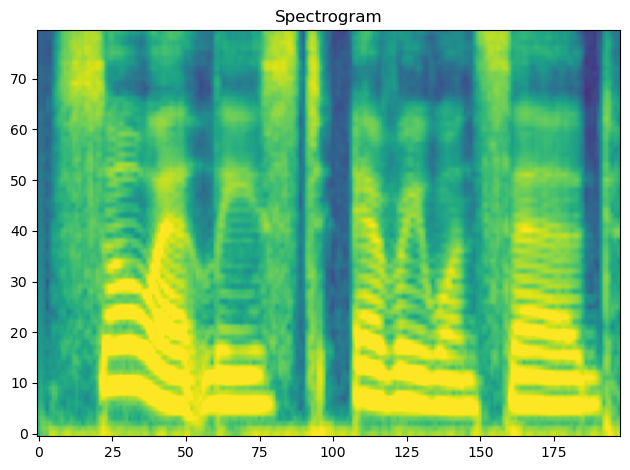

In [5]:
# Load audio
index = 1
waveform = load_mono_audio(files[index], sample_rate = config.audio.sample_rate)
spec = spectogram(waveform, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)
tokens, _ = extract_tokens(tg[index])
tokens = tokens.to(device)
spec = spec[:, :len(tokens)]

tokens = torch.nn.functional.pad(tokens, (35, 35), "constant", tokenizer.silence_token_id)

# Source audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

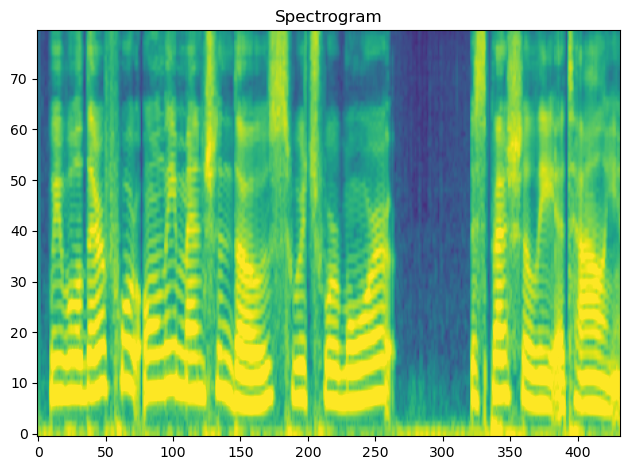

In [6]:
# Load conditioning audio
cond_index = 4
cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
cond_spec = spectogram(cond_waveform, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)
cond_tokens, _ = extract_tokens(tg[cond_index])
cond_spec = cond_spec[:, :len(cond_tokens)]

# Source audio
display(Audio(data=cond_waveform, rate=config.audio.sample_rate))
plot_specgram(cond_spec.cpu())

# Synthesize unconditioned voice
This synthesizes random voice from existing phonemes (taken from another file)

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 35, 35, 35, 35, 35, 76,
        76, 76, 76, 76, 76, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35,  1,  1,  1,  1, 57, 57, 57, 57, 57, 57, 57,
        57, 57, 57, 41, 41, 41, 41, 55, 55, 55, 68, 68, 68, 18, 18, 18, 18, 18,
        43, 43, 43, 43, 43, 43, 49, 49, 49, 49, 49, 49, 28, 28, 28, 28, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 57, 57, 57, 57, 57, 57, 57,
        57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 69, 69, 69,
        69, 69, 69, 69, 69, 69, 69, 69, 

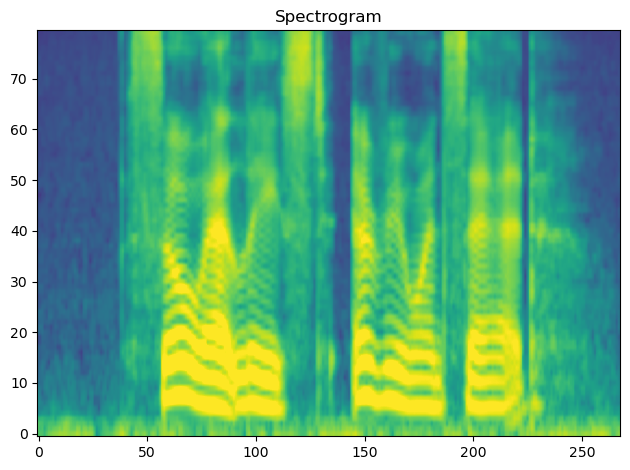

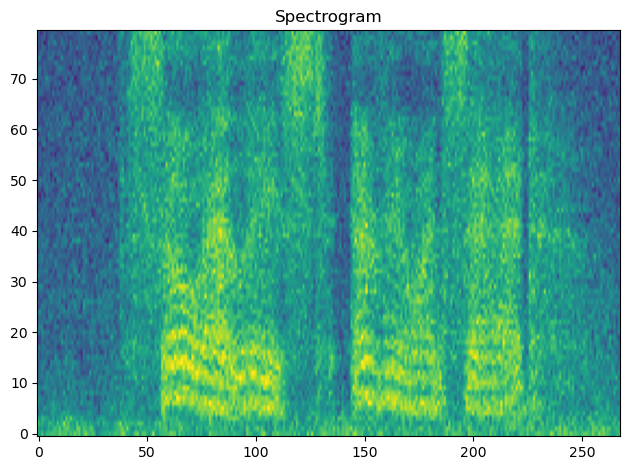

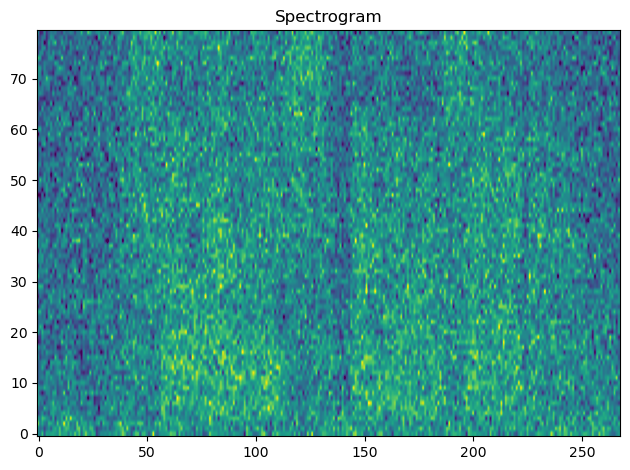

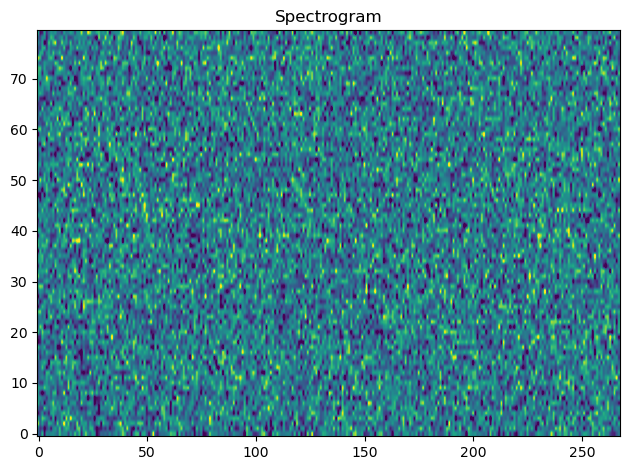

In [23]:
with torch.no_grad():
    sample, trajectory = model.sample(
        tokens = tokens, 
        audio = torch.zeros((len(tokens), 80)).to(device),  # Empty source audio
        mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)
print(tokens)

# Resynth
resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Restore segment
Cut part of the audio and re-generate segment

In [8]:
with torch.no_grad():

    # Create a mask
    seq_len = len(tokens)
    mask = torch.zeros((seq_len)).bool().to(device)
    mask[math.floor(seq_len * 0.3): math.floor(seq_len * 0.6)] = True

    # Restore audio
    sample, trajectory = model.sample(
        tokens = tokens, 
        audio = audio_normalize(spec.transpose(1,0)),  # Source audio (will be masked by model)
        mask = mask, 
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

RuntimeError: The size of tensor a (268) must match the size of tensor b (198) at non-singleton dimension 0

### Conditioned TTS

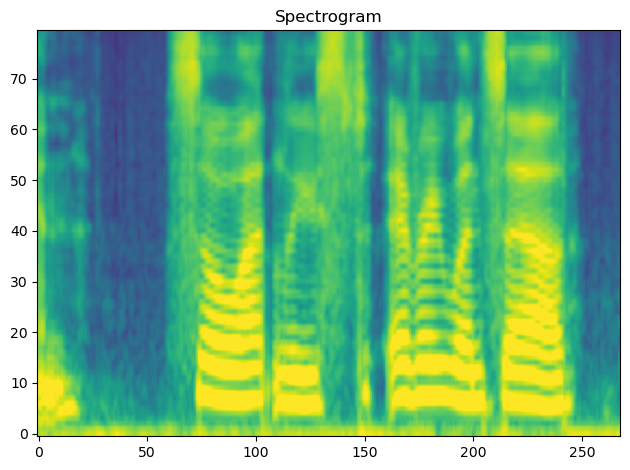

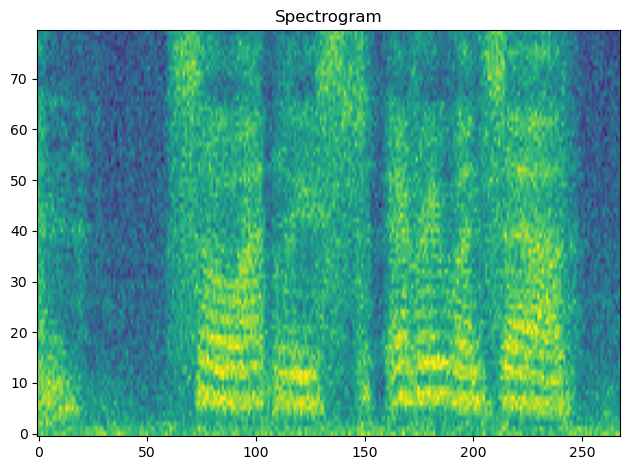

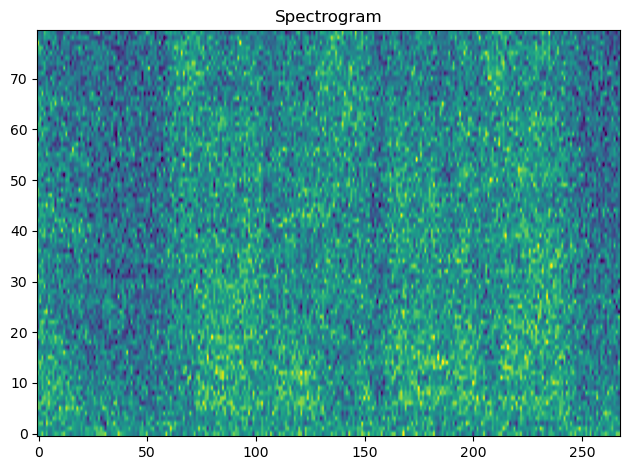

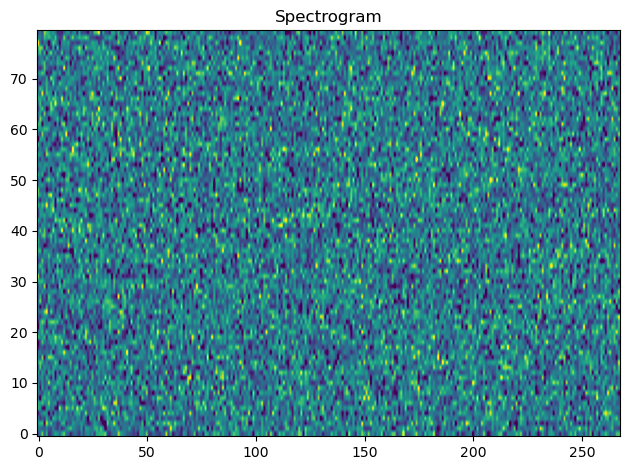

In [9]:
with torch.no_grad():

    # Create a mask
    mask = torch.zeros((len(cond_tokens) + len(tokens))).bool().to(device)
    mask[len(cond_tokens):len(cond_tokens) + len(tokens)] = True

    s = torch.cat([cond_spec.transpose(1,0), torch.zeros(len(tokens), 80)])
    
    # mask[math.floor(seq_len * 0.3): math.floor(seq_len * 0.6)] = True

    # Restore audio
    sample, trajectory = model.sample(
        tokens = torch.cat([cond_tokens, tokens]),
        audio = audio_normalize(s),  # Source audio (will be masked by model)
        mask = mask, 
        steps = 4
    )
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)
    sample = sample[len(cond_tokens):]
    trajectory = trajectory[:,len(cond_tokens):]

# Resynth
resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
display(Audio(data=waveform, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
for i in reversed(range(len(trajectory))):
    plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Variativity

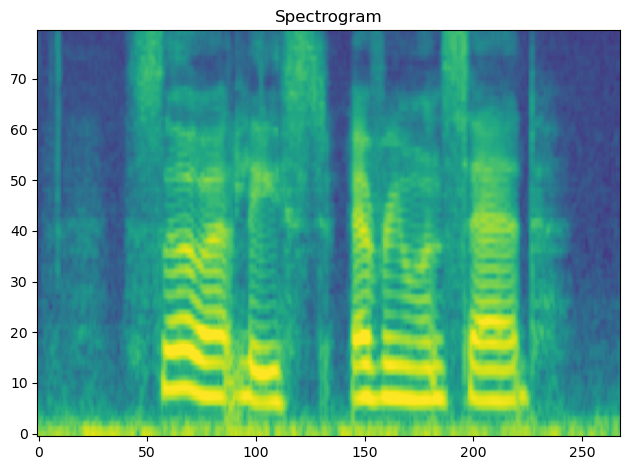

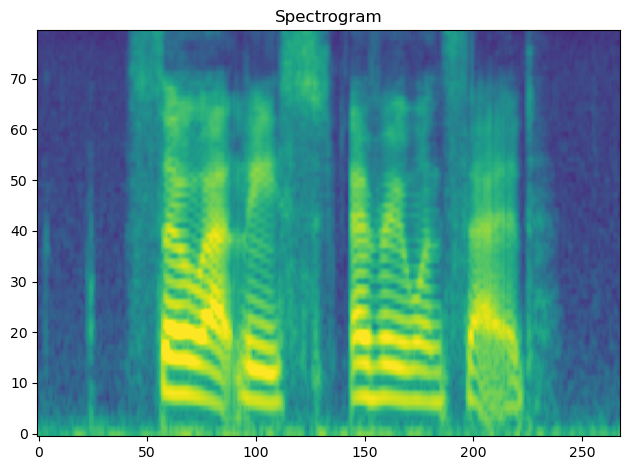

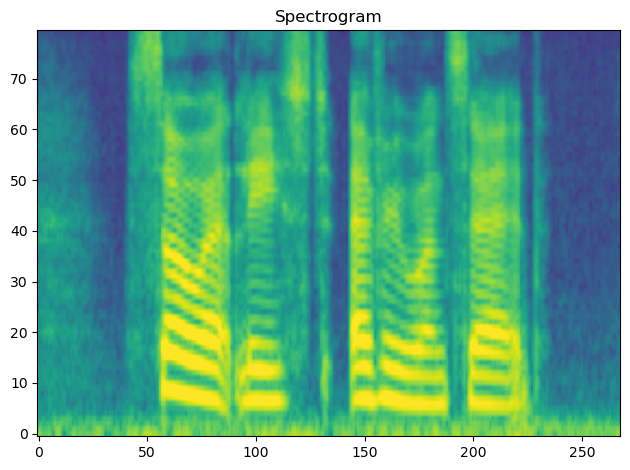

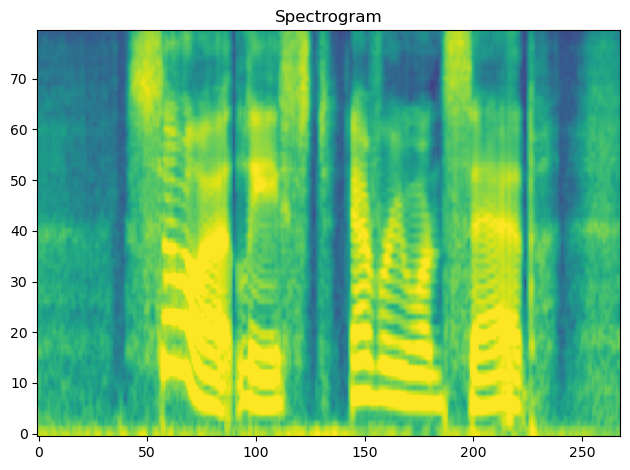

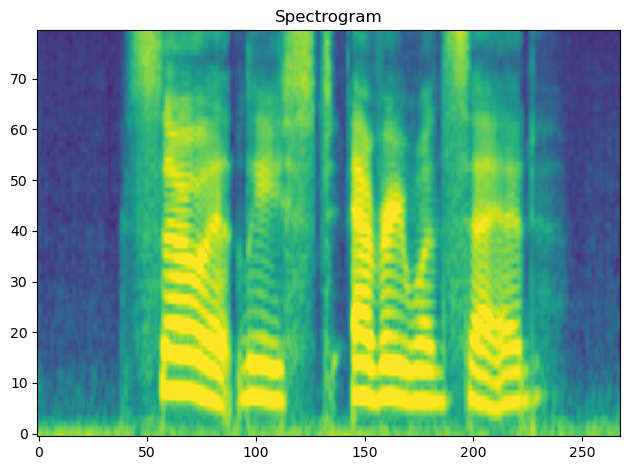

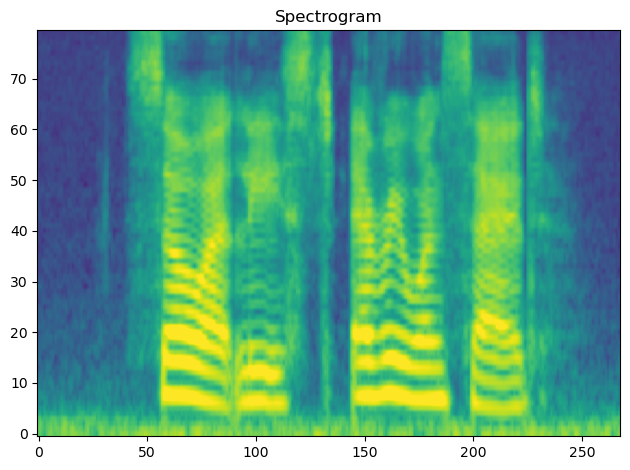

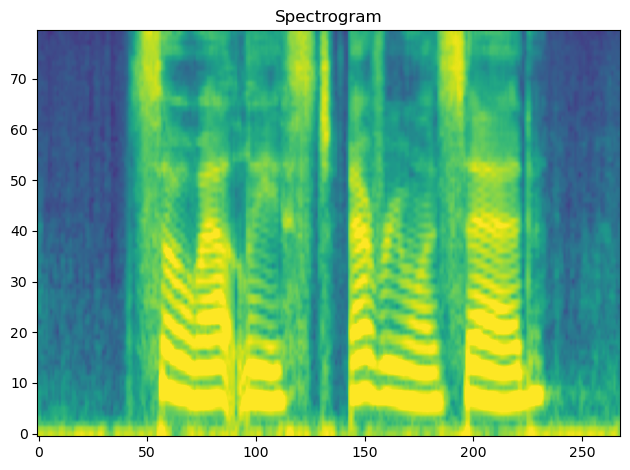

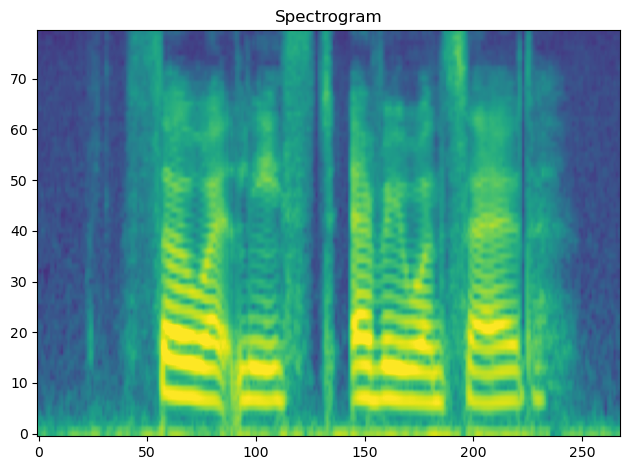

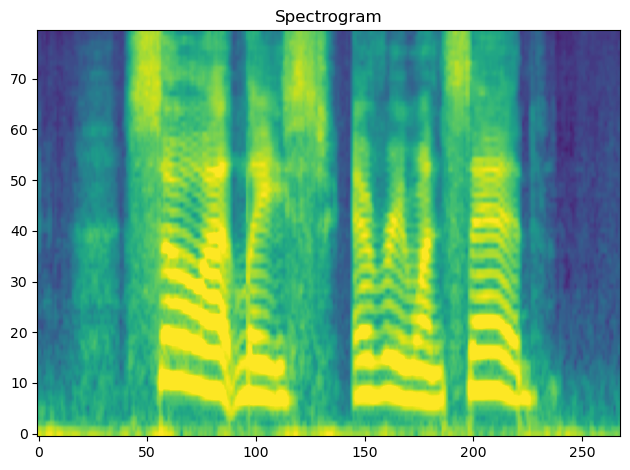

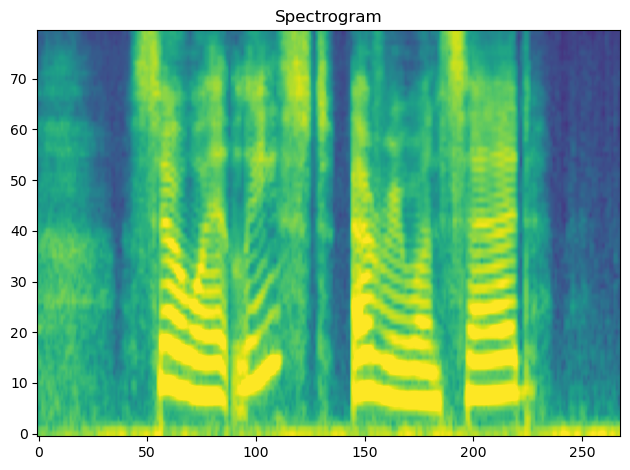

In [26]:
for i in range(10):
    with torch.no_grad():
        sample, trajectory = model.sample(
            tokens = tokens, 
            audio = torch.zeros((len(tokens), 80)).to(device),  # Empty source audio
            mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
            steps = 32
        )
        sample = audio_denormalize(sample)
        resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
        display(Audio(data=resynth, rate=config.audio.sample_rate))
        plot_specgram(sample.transpose(1,0).cpu())    

# Resynth
# resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# # Display audio
# display(Audio(data=waveform, rate=config.audio.sample_rate))
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    